In [1]:
%matplotlib inline

import numpy as np
import jax
import jax.numpy as jnp
from scenic.projects.owl_vit import configs
from scenic.projects.owl_vit import models
print("Using", jax.default_backend())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-22 04:36:23.267725: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Using gpu


In [2]:
import inference

In [3]:
config = configs.owl_v2_clip_b16.get_config(init_mode='canonical_checkpoint')
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)
variables = module.load_variables("checkpoints/owl_vit")

In [4]:
%%time
model = inference.Model(config, module, variables)
model.warm_up()

100%|█████████████████████████████████████| 1.29M/1.29M [00:00<00:00, 11.6MiB/s]


CPU times: user 1min 6s, sys: 1.52 s, total: 1min 7s
Wall time: 16.1 s


In [45]:
def cxcywh_to_xywh(image, box):
    cx, cy, w, h = box
    if np.max(box) <= 1.0:
        height, width = image.shape[:2]
        cx = cx * width
        cy = cy * height
        w = w * width
        h = h * height
    x1 = cx - int(w/2)
    y1 = cy - int(h/2)
    x2 = cx + int(w/2)
    y2 = cy + int(h/2)
    return (x1, y1, x2-x1, y2-y1)

def xyxy_to_xywh(image, box):
    x1, y1, x2, y2 = box
    if np.max(box) <= 1.0:
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)
    return (x1, y1, x2 - x1, y2 - y1)

def draw_boxes(image, box_groups):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(image)
    colors = ['red', 'green', 'blue']
    for i, group in enumerate(box_groups):
        for box in group:
            rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2,
                                     edgecolor=colors[i], facecolor='none')
            ax.add_patch(rect)
    plt.show()

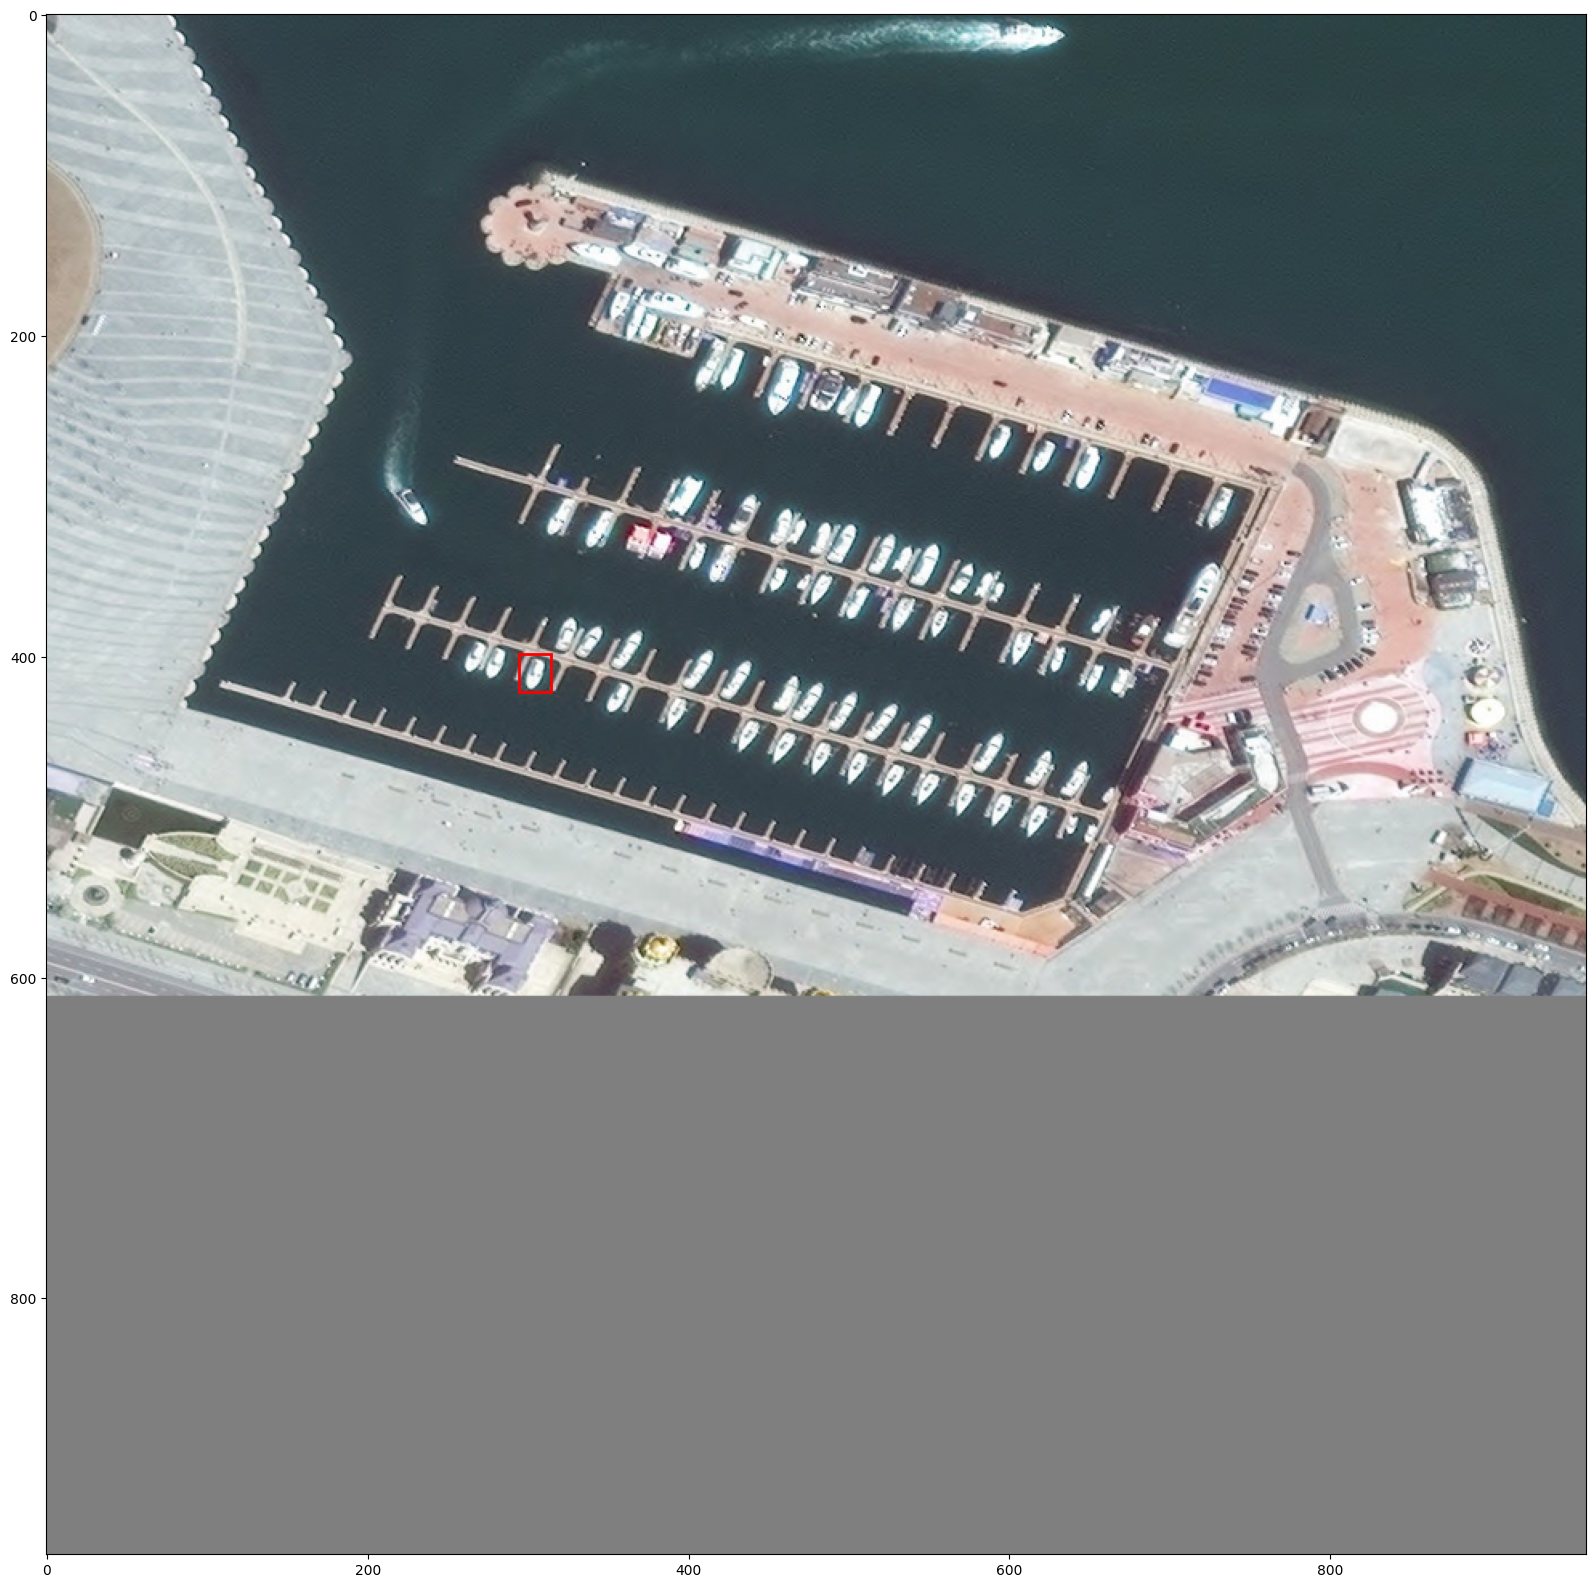

In [46]:
import PIL
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

PIL.Image.MAX_IMAGE_PIXELS = 933120000
image_name = 'zoomed-in-docks.jpg'
image = PIL.Image.open(image_name)
image_arr = np.array(image)
processed = model.preprocess_image(image_arr)

query_box = (294, 398, 314, 422)
query_xywh = xyxy_to_xywh(processed, query_box)
draw_boxes(processed, [[query_xywh]])

In [41]:
# https://github.com/google-research/scenic/blob/main/scenic/projects/owl_vit/notebooks/interactive.py#L164

# TensorFlow format (y_min, x_min, y_max, x_max), normalized to [0, 1]
tf_box = (float(query_box[1] / height), float(query_box[0] / width), float(query_box[3] / height), float(query_box[2] / width))
query_embedding, best_box_ind = model.embed_image_query(image_arr, tf_box)
_, _, query_image_boxes = model.embed_image(image_arr)

top_query_ind, scores = model.get_scores(
    image_arr, query_embedding[None, ...], num_queries=1)

In [42]:
# https://github.com/google-research/scenic/blob/main/scenic/projects/owl_vit/notebooks/interactive.py#L184
from scenic.model_lib.base_models import box_utils

IMAGE_COND_NMS_IOU_THRESHOLD = 0.2

if IMAGE_COND_NMS_IOU_THRESHOLD < 1.0:
    _, _, target_image_boxes = model.embed_image(image_arr_uint8)
    target_boxes_yxyx = box_utils.box_cxcywh_to_yxyx(target_image_boxes, np)
    for i in np.argsort(-scores):
      if not scores[i]:
        # This box is already suppressed, continue:
        continue
      ious = box_utils.box_iou(
          target_boxes_yxyx[None, [i], :],
          target_boxes_yxyx[None, :, :],
          np_backbone=np)[0][0, 0]
      ious[i] = -1.0  # Mask self-IoU.
      scores[ious > IMAGE_COND_NMS_IOU_THRESHOLD] = 0.0

In [59]:
IMAGE_COND_MIN_CONF = 0.9997

alphas = np.zeros_like(scores)
for i in range(1):
    # Select scores for boxes matching the current query:
    query_mask = top_query_ind == i
    query_scores = scores[query_mask]
    if not query_scores.size:
      continue
    
    # Box alpha is scaled such that the best box for a query has alpha 1.0 and
    # the worst box for which this query is still the top query has alpha 0.1.
    # All other boxes will either belong to a different query, or will not be
    # shown.
    max_score = np.max(query_scores) + 1e-6
    query_alphas = (query_scores - (max_score * 0.1)) / (max_score * 0.9)
    query_alphas[query_alphas < IMAGE_COND_MIN_CONF] = False
    query_alphas[query_alphas >= IMAGE_COND_MIN_CONF] = True
    alphas[query_mask] = query_alphas.astype(bool)

(69, 4)


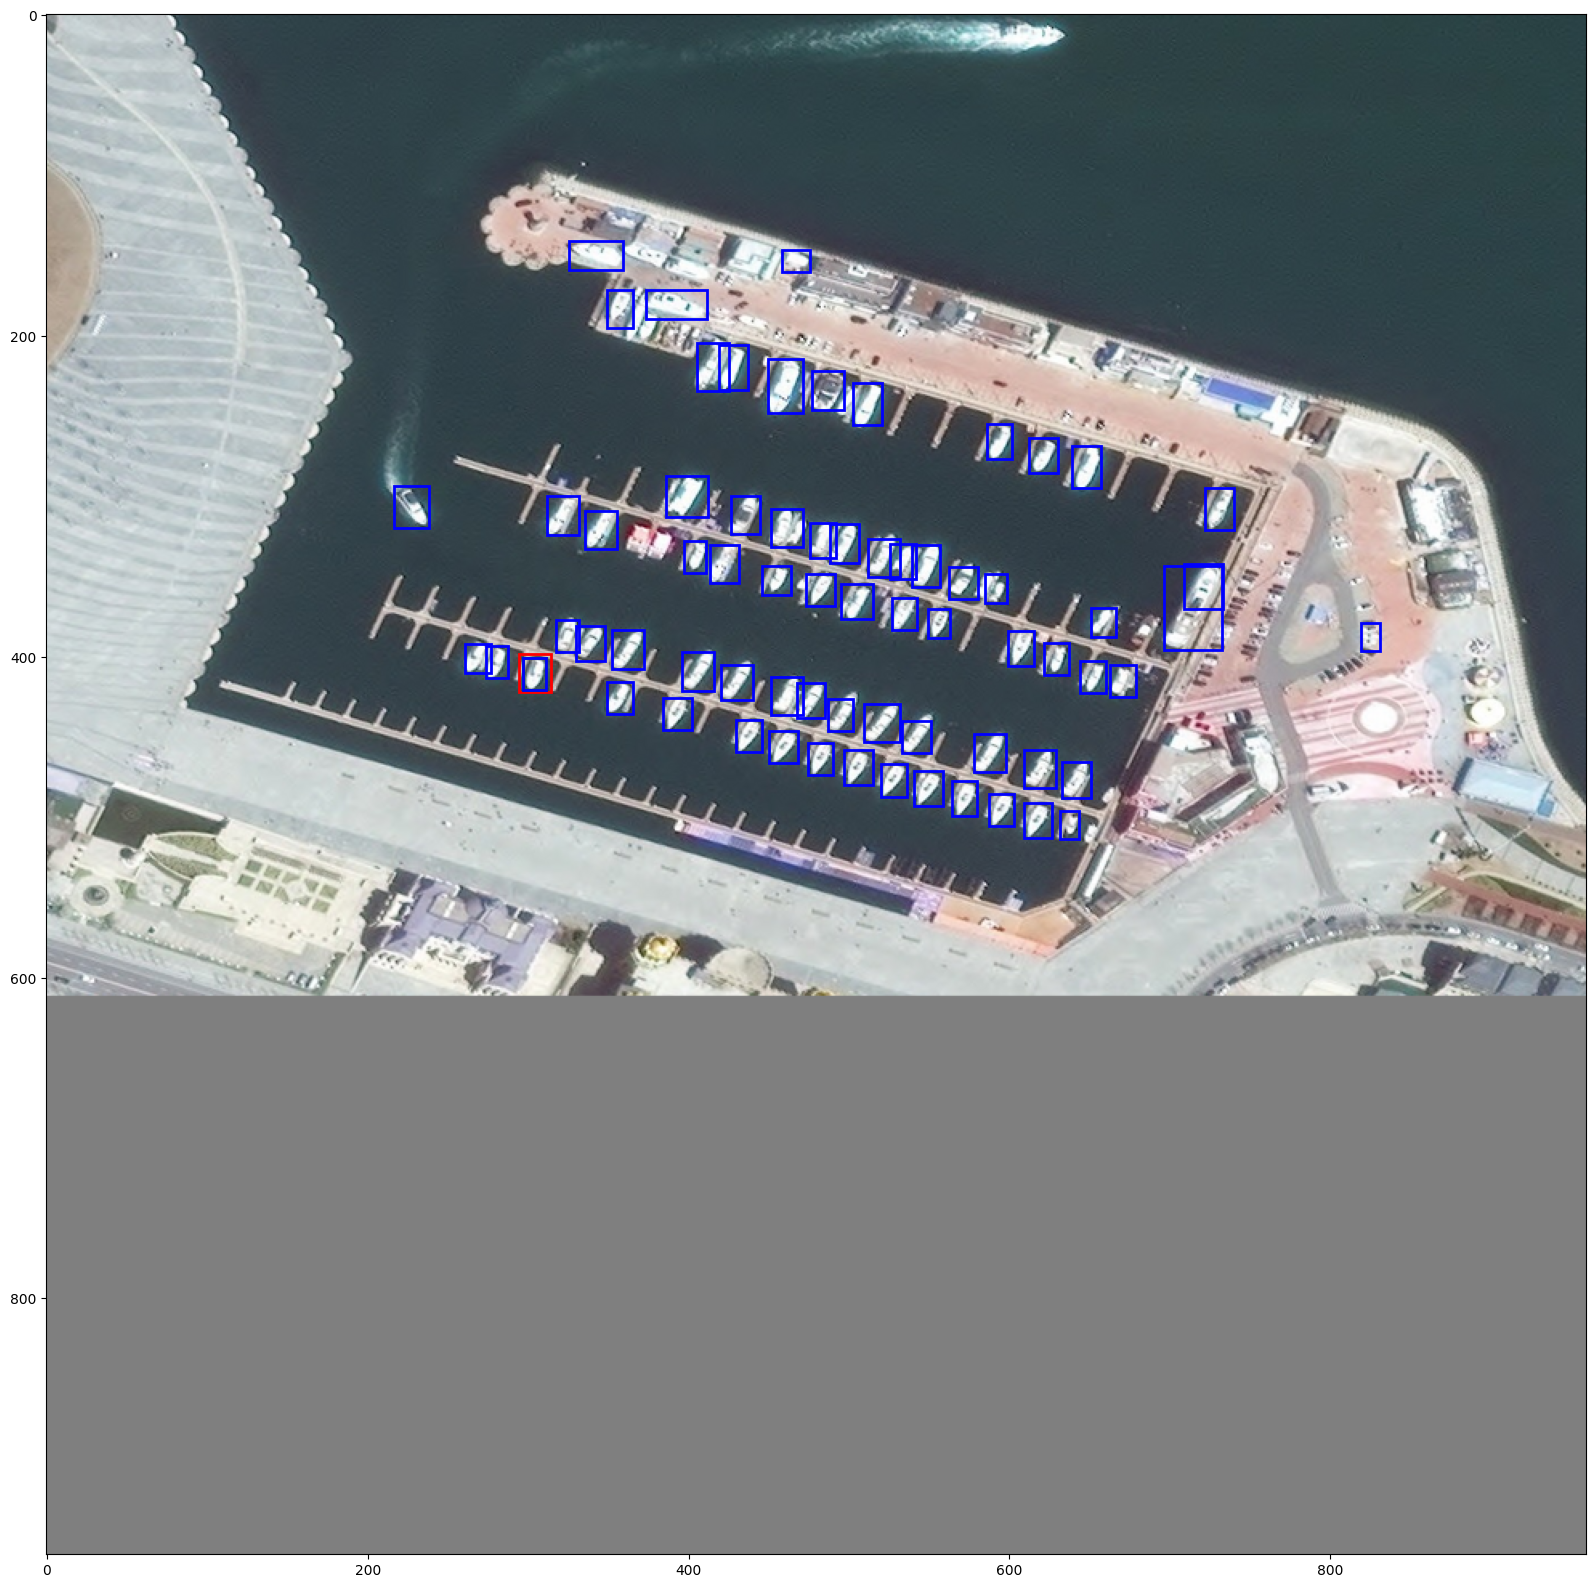

In [65]:
chosen_query_box = tuple((float(c) for c in query_image_boxes[best_box_ind]))
chosen_query_xywh = cxcywh_to_xywh(processed, chosen_query_box)

target_boxes = []
for box in query_image_boxes[alphas.astype(bool)]:
    target_boxes.append(cxcywh_to_xywh(processed, box))

draw_boxes(processed, [[query_xywh], [chosen_query_xywh], target_boxes])